In [1]:
import sys
sys.path.insert(0, "../../..")
from paths import DATA_DIR, FIG_DIR

import pandas as pd
import scanpy as sc
import scvelo as scv

from graphvelo.mo import gen_wnn
from graphvelo.graph_velocity import GraphVelo
from graphvelo.utils import gene_wise_confidence

In [2]:
scv.settings.verbosity = 3
scv.settings.set_figure_params('scvelo', dpi_save=300, dpi=80, transparent=True, fontsize=20)
scv.settings.plot_prefix = ""
scv.settings.figdir = str(FIG_DIR)

In [3]:
save_fig = True

In [4]:
cell_info_file = DATA_DIR / "share_seq" / "cell_info.txt"
lsi_file = DATA_DIR / "share_seq" / "scatac_LSI.csv"
mv_rna_file = DATA_DIR / "share_seq" / "adata_postpro.h5ad"
mv_atac_file = DATA_DIR / "share_seq" / "adata_atac_postpro.h5ad"
X_lsi = pd.read_csv(lsi_file, sep='\t').values
cell_info = pd.read_csv(cell_info_file, sep="\t")
cell_info.index = cell_info['cell_name_atac']

In [5]:
palette = {'TAC-1': '#a76b9a',
 'IRS': '#da96ff',
 'Medulla': '#ad94ec',
 'TAC-2': '#2f3ea8',
 'Hair Shaft-cuticle.cortex': '#d70000'}

In [6]:
adata = sc.read(mv_rna_file)
adata_atac = sc.read(mv_atac_file)
adata.obs.index = adata.obs.index.str.replace(',', '.')
adata_atac.obs.index = adata_atac.obs.index.str.replace(',', '.')
shared_cells = adata.obs_names.intersection(cell_info.index)
adata = adata[shared_cells]
adata_atac = adata_atac[shared_cells]

In [7]:
idx = [cell_info.index.get_loc(i) for i in adata.obs_names]
X_lsi = X_lsi[idx]
adata.obsm['X_lsi'] = X_lsi

In [8]:
adata = gen_wnn(adata, copy=True, k=50)

0 out of 6431 0.00 seconds elapsed
2000 out of 6431 4.31 seconds elapsed
4000 out of 6431 8.63 seconds elapsed
6000 out of 6431 12.70 seconds elapsed


In [9]:
adata.uns['neighbors'] = adata.uns['WNN'].copy()
adata.obsp['connectivities'] = adata.obsp['WNN'].copy()
adata.obsp['distances'] = adata.obsp['WNN_distance'].copy()

In [10]:
# # smooth chromatin signal based on WNN
adata.layers['Mc'] = adata.obsp['WNN'] @ adata_atac.X

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 10/10 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:17) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 10/10 cores)
    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 5 regions of root cells and 1 region of end points .
    finished (0:00:01) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared t

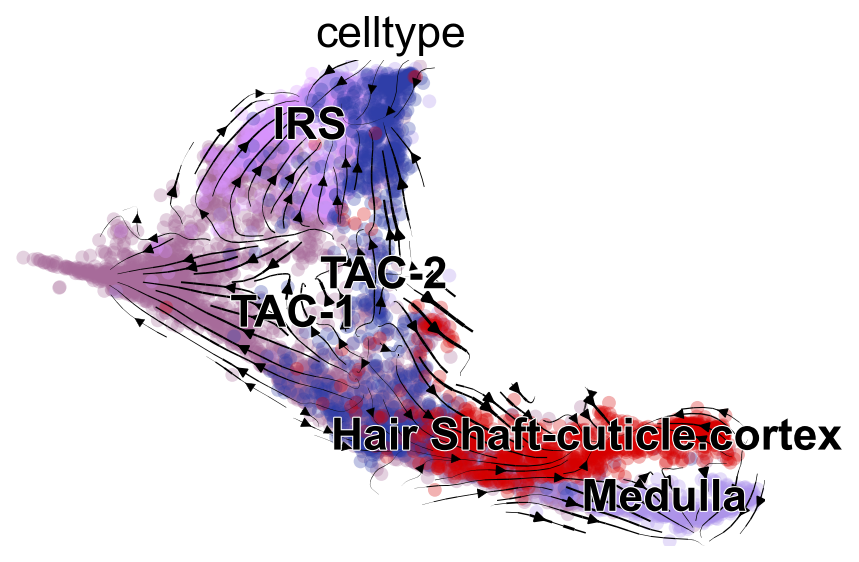

In [11]:
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
scv.tl.recover_dynamics(adata, n_jobs=-1)
scv.tl.velocity(adata)
scv.tl.velocity_graph(adata, n_jobs=-1)
scv.tl.latent_time(adata)
scv.pl.velocity_embedding_stream(adata, basis='umap', color=['celltype'], palette=palette)

In [12]:
# dynamo criteria
gene_wise_confidence(adata, group='celltype', lineage_dict={'TAC-1': ['IRS', 'Hair Shaft-cuticle.cortex', 'Medulla']}, ekey='Ms', vkey='velocity')
percent = 0.8
confident_genes = adata.var.index[(adata.var['avg_prog_confidence']>percent) | (adata.var['avg_mature_confidence']>percent)]
len(confident_genes)

calculating gene velocity vectors mack_val based on phase portrait location with priors of progenitor/mature cell types: 962it [00:01, 776.02it/s]


192

In [15]:
pd.DataFrame(confident_genes).to_csv('confident_genes.csv')

computing velocity graph (using 4/10 cores)
    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


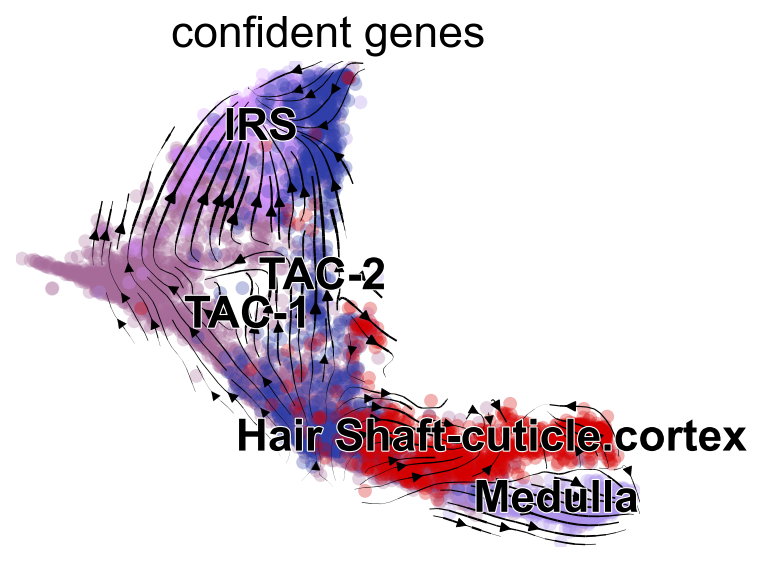

In [17]:
scv.tl.velocity_graph(adata, gene_subset=confident_genes, n_jobs=4)
scv.pl.velocity_embedding_stream(adata, color='celltype', basis='umap', figsize=(5, 4), title='confident genes')

## Apply GraphVelo based on RNA velocity of confident genes

Learning Phi in tangent space projection.: 100%|██████████| 6431/6431 [00:06<00:00, 992.26it/s] 


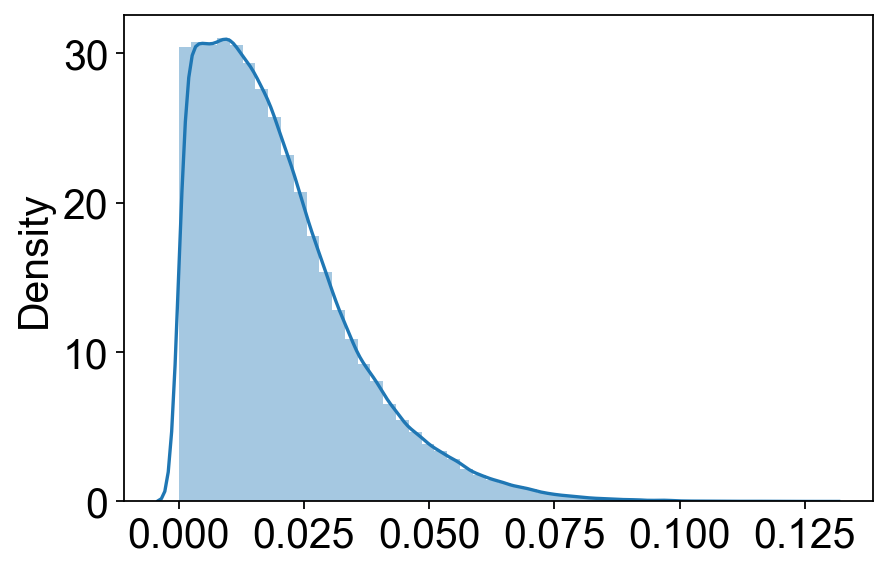

In [18]:
gv = GraphVelo(adata, gene_subset=confident_genes)
gv.train()
gv.write_to_adata(adata, key='gv')
gv.plot_phi_dist()

In [19]:
adata.layers['velocity_gv'] = gv.project_velocity(adata.layers['Ms'])
adata.layers['velocity_c'] = gv.project_velocity(adata.layers['Mc'])
adata.obsm['gv_pca'] = gv.project_velocity(adata.obsm['X_pca'])
adata.obsm['gv_umap'] = gv.project_velocity(adata.obsm['X_umap'])

projecting velocity vector to low dimensional embedding: 100%|██████████| 6431/6431 [00:03<00:00, 2106.40it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 6431/6431 [00:03<00:00, 1904.07it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 6431/6431 [00:00<00:00, 17463.39it/s]
projecting velocity vector to low dimensional embedding: 100%|██████████| 6431/6431 [00:00<00:00, 18442.19it/s]


saving figure to file /Users/yuhaochen/Documents/GitHub/graphvelo_reproducibility/figures/multiomics_figures/gv.svg


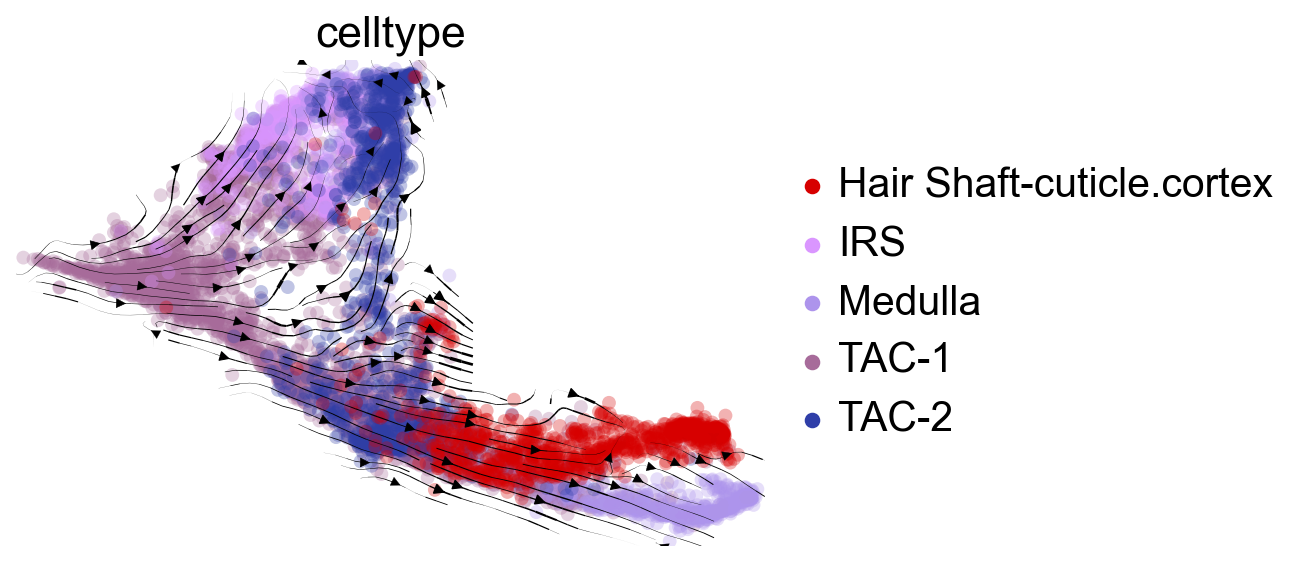

In [22]:
fig_kwargs = {'color': 'celltype', 'basis': 'umap', 'X': adata.obsm['X_umap'], 'V': adata.obsm['gv_umap'], 'legend_loc': 'right'}
if save_fig: fig_kwargs['save'] = scv.settings.figdir + "/multiomics_figures/gv.svg"
scv.pl.velocity_embedding_stream(adata, **fig_kwargs)

In [21]:
adata.write('adata_gv.h5ad')